In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 9,935
training + validation N: 40,583


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0,1,0,0,0,0,0,0,0,0,AAAAAAAGTGAGTTAGCCAACTAATTAGGCACCGTACGCTTTATAG...
1,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGAGAGTTAGTTCACTCATTCGGCACCACAGGCTTTACAA...
2,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGGGTGTTAGCTCTATCATTAGGCACCCCCGGCTTTACAC...
3,training,0,1,0,0,0,0,0,0,0,0,AAAAAATGTCAGTTAGCTGACTCATTAGGCACCCCTGGCTTTACGT...
4,validation,0,0,0,0,0,0,1,0,0,0,AAAAAATGTGAGAAAGCTCACTCCTTTGGCACCGCAGGCTTTACAC...


In [3]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A','C','G','T']

y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

# get test set data.
x_test = test_df['x'].values

L=75, Y=10


In [4]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-03-29 00:01:34.441744: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [5]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=10,
                                                                      K=50,
                                                                      eta=1e-5,)


In [6]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

In [7]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 310)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 300)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           301         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [8]:
# Set training data
model.set_data(x=data_df['x'].values,
               y_list=[data_df[y_cols].values],
               validation_flags=(data_df['set']=='validation'),
               shuffle=False)


N = 40,583 observations set as training data.
Using 24.8% for validation.
Time to set data: 1.11 sec.


In [9]:

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/1000
62/62 [==============================] - 1s 9ms/step - loss: 1175.9475 - I_var: 0.0130 - val_loss: 1124.7837 - val_I_var: 0.1362
Epoch 2/1000
62/62 [==============================] - 0s 6ms/step - loss: 1046.4801 - I_var: 0.3806 - val_loss: 988.6919 - val_I_var: 0.5273
Epoch 3/1000
62/62 [==============================] - 0s 5ms/step - loss: 994.4573 - I_var: 0.5236 - val_loss: 998.8061 - val_I_var: 0.5008
Epoch 4/1000
62/62 [==============================] - 0s 5ms/step - loss: 985.4398 - I_var: 0.5532 - val_loss: 977.4054 - val_I_var: 0.5593
Epoch 5/1000
62/62 [==============================] - 0s 5ms/step - loss: 978.4114 - I_var: 0.5719 - val_loss: 967.5831 - val_I_var: 0.5880
Epoch 6/1000
62/62 [==============================] - 0s 5ms/step - loss: 972.8793 - I_var: 0.5853 - val_loss: 962.4884 - val_I_var: 0.5992
Epoch 7/1000
62/62 [==============================] - 0s 5ms/step - loss: 969.6298 - I_var: 0.6010 - val_loss: 965.9338 - val_I_var: 0.5919
Epoch 8/1000
62/6

On test data:


Text(0.5, 1.0, 'training hisotry')

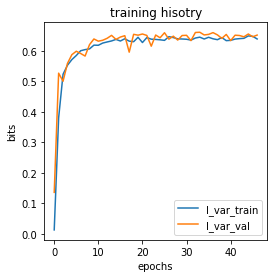

In [14]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

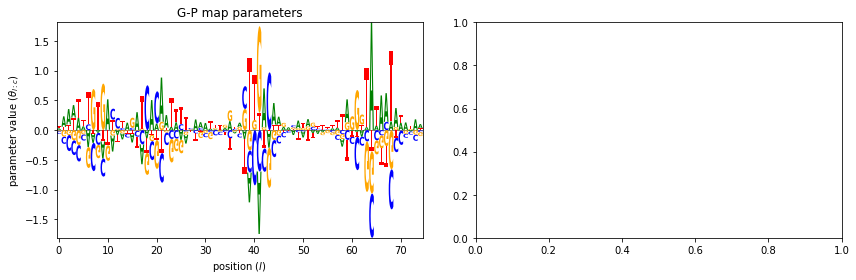

In [39]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('sortseq_g-p_map_mpa_visualization.png')
plt.show()